In [1]:
from scipy.stats import laplace, norm
import numpy as np
import matplotlib.pyplot as plt
from jax import vmap

from discrepancies import MaximumMeanDiscrepancy, KernelSteinDiscrepancy
from distributions import Gaussian, Mixture
from kernels import (
    PolynomialKernel,
    GaussianKernel,
    LaplacianKernel,
    InverseMultiQuadraticKernel,
    SteinKernel,
)

# Witness Functions

## MMD

Recall that the Maximum Mean Discrepancy (MMD) is given by:

$$MMD = \sup_{f\in F} \{ \int f(x) d \mathbb{P}(x)-\int f(y) d \mathbb{Q}(y) \}$$

where $F:= \{||f||_H \leq 1 \}$.

For this section, we are interested in the function $f$ which maximises $\int f(x) d \mathbb{P}(x)-\int f(y) d \mathbb{Q}(y)$ or in other words, the function chosen by the supremum. This function is known as the witness function.

The witness function $f^*$ can expressed:

$$f^*(t) \propto \langle \phi(t), \mu_p - \mu_q\rangle_H = \mathbb{E}_x[k(x, t)]-\mathbb{E}_y[k(y, t)]$$

We can estimate this function with:

$$\hat{f}^*(t) \propto \langle \phi(t), \mu_p - \mu_q\rangle_H = \frac{1}{m}\sum_{i=1}^{m}k(x_i, t)-\frac{1}{n}\sum_{i=1}^{n} k(y_i, t)$$

## KSD

Moreover, we know for the Stein kernl $k_{\mathbb{P}}$ that:

$$\mathbb{E}_x[k_{\mathbb{P}}(x, t)] = 0$$

for all t, when $x \sim \mathbb{P}$.

So for the KSD, we can estimate the witness function $f^*$ with:

$$\hat{f}^*(t) \propto \langle \phi(t), \mu_p - \mu_q\rangle_H = -\frac{1}{n}\sum_{i=1}^{n} k_{\mathbb{P}}(y_i, t)$$

# Gaussian vs Laplace Example

We can plot the witness function between Gaussian and Laplace Distributions:

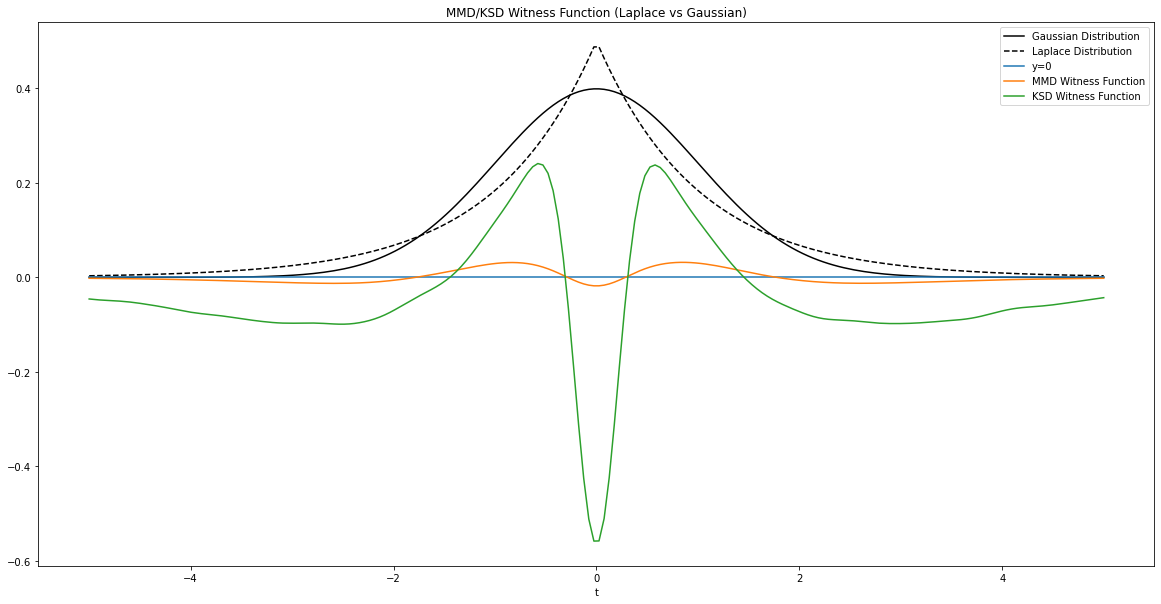

In [2]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(20)
fig.set_figheight(10)

n_p1_samples = int(1e6)
n_p2_samples = int(1e6)
p1 = Gaussian(mu=np.zeros((1,)), covariance=np.eye(1))
p1_samples = p1.sample(n_p1_samples)
p2_samples = np.random.laplace(loc=0.0, scale=1.0, size=n_p2_samples).reshape(-1, 1)
t = np.linspace(-5, 5, 200).reshape(-1, 1)
sigma = 10

mmd = MaximumMeanDiscrepancy(kernel=GaussianKernel(sigma))
mmd_witness_values = mmd.witness_function(p1_samples, p2_samples, t)

stein_kernel = SteinKernel(distribution=p1, kernel=GaussianKernel(sigma))
ksd = KernelSteinDiscrepancy(stein_kernel=stein_kernel)
ksd_witness_values = ksd.witness_function(p2_samples, t)

ax.plot(t, vmap(lambda t_i: p1.p(t_i))(t), label="Gaussian Distribution", c="black")
ax.plot(t, laplace.pdf(t), label="Laplace Distribution", c="black", linestyle="dashed")
ax.plot(t, np.zeros(t.shape), label="y=0")
ax.plot(t, mmd_witness_values, label="MMD Witness Function")
ax.plot(t, ksd_witness_values, label="KSD Witness Function")
ax.set_title("MMD/KSD Witness Function (Laplace vs Gaussian)")
ax.set_xlabel("t")
ax.legend()
plt.show()

The quality of the witness function approximation can depend quite sigificantly on the number of samples availble. Here we show the witness function converging as we increase the number of samples from both distributions.

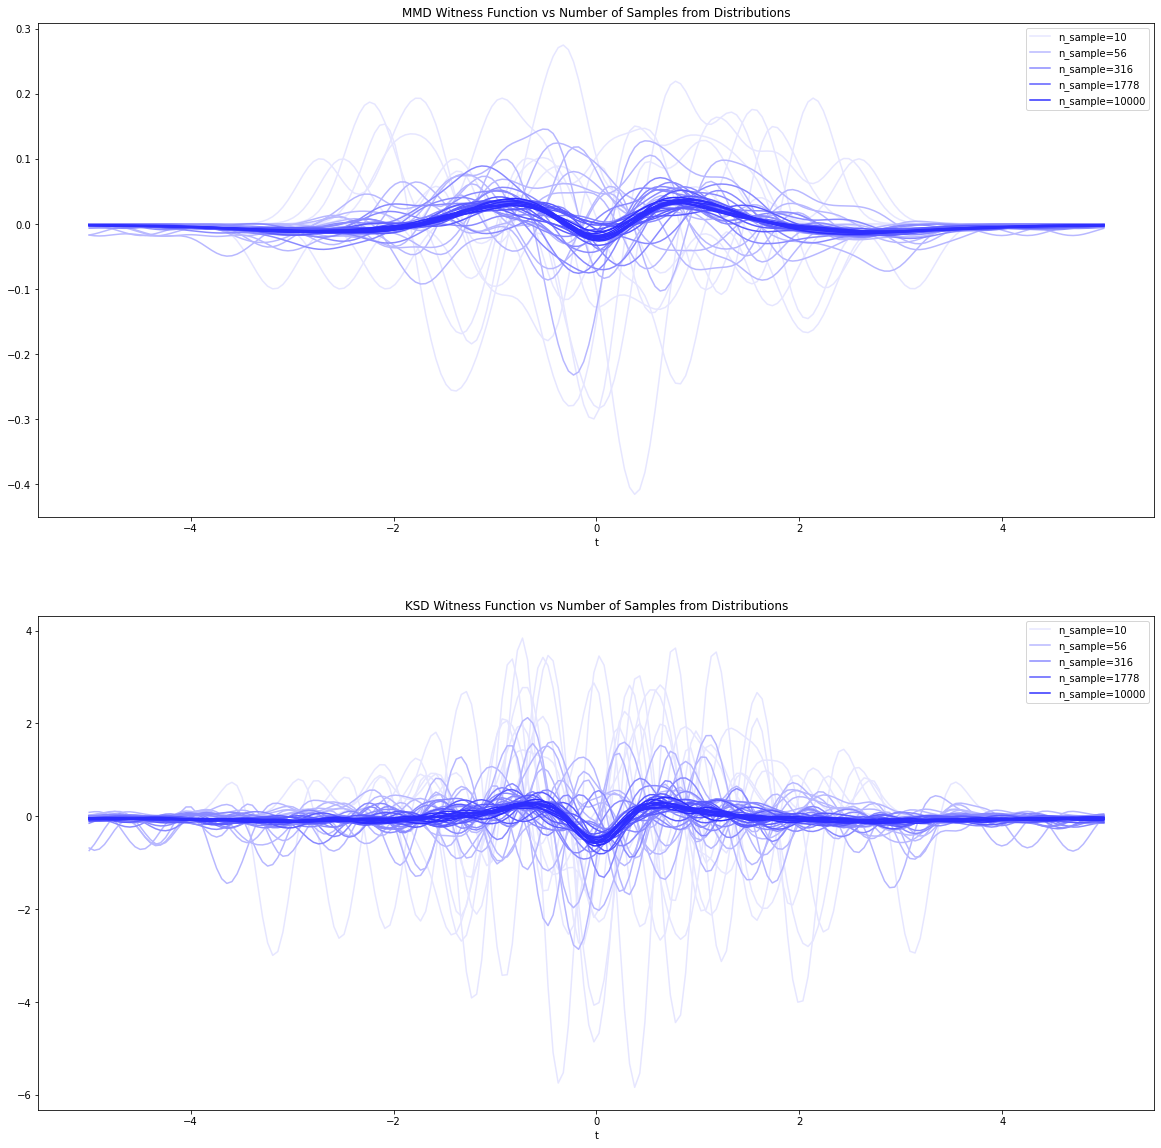

In [3]:
n_trials = 10
n_samples = np.logspace(1, 4, 5).astype(int)
fig, ax = plt.subplots(2, 1)
fig.set_figwidth(20)
fig.set_figheight(20)
sigma = 10
t = np.linspace(-5, 5, 200).reshape(-1, 1)
p1 = Gaussian(mu=np.zeros((1,)), covariance=np.eye(1))

mmd = MaximumMeanDiscrepancy(kernel=GaussianKernel(sigma))
stein_kernel = SteinKernel(distribution=p1, kernel=GaussianKernel(sigma))
ksd = KernelSteinDiscrepancy(stein_kernel=stein_kernel)
for i, n_sample in enumerate(n_samples):
    for j in range(n_trials):
        x = p1.sample(n_sample)
        y = np.random.laplace(loc=0.0, scale=1.0, size=n_sample).reshape(-1, 1)
        mmd_witness_values = mmd.witness_function(x, y, t)
        ksd_witness_values = ksd.witness_function(
            x=y,
            t=t,
        )
        shade = 0.9 * (len(n_samples) - i) / len(n_samples)
        if j == 0:
            ax[0].plot(
                t,
                mmd_witness_values,
                c=(shade, shade, 1),
                label=f"{n_sample=}",
            )
            ax[1].plot(
                t,
                ksd_witness_values,
                c=(shade, shade, 1),
                label=f"{n_sample=}",
            )
        else:
            ax[0].plot(t, mmd_witness_values, c=(shade, shade, 1))
            ax[1].plot(t, ksd_witness_values, c=(shade, shade, 1))

ax[0].set_title("MMD Witness Function vs Number of Samples from Distributions")
ax[0].set_xlabel("t")
ax[0].legend()
ax[1].set_title("KSD Witness Function vs Number of Samples from Distributions")
ax[1].set_xlabel("t")
ax[1].legend()
plt.show()

# Comparing Kernels

We can also see how the kernel parameters can influence the shape of the witness function.

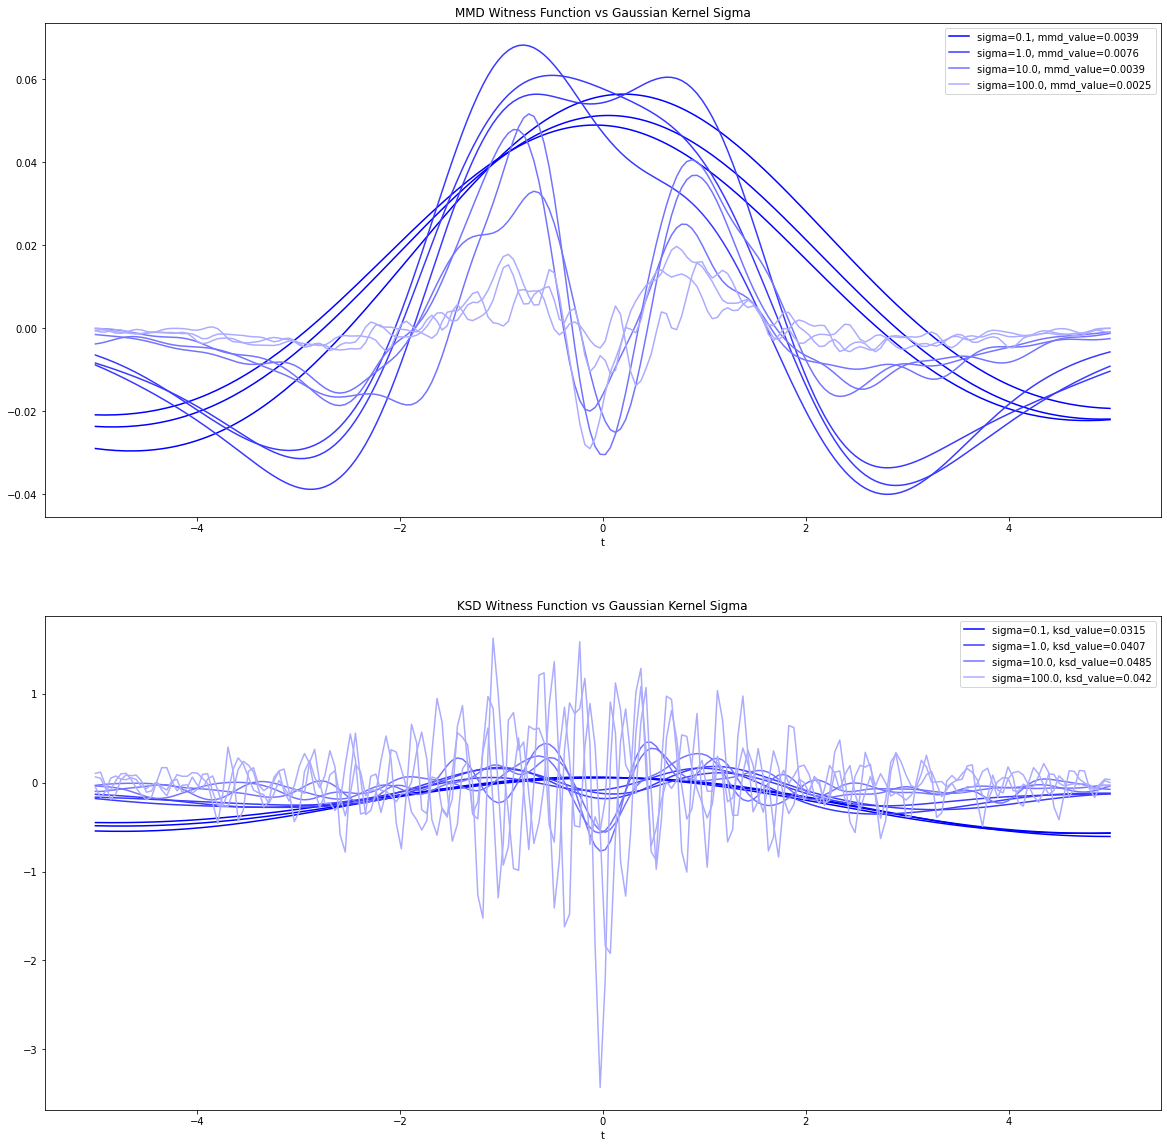

In [4]:
n_trials = 3
fig, ax = plt.subplots(2, 1)
fig.set_figwidth(20)
fig.set_figheight(20)
n_sample = int(2e3)
t = np.linspace(-5, 5, 200).reshape(-1, 1)
p1 = Gaussian(mu=np.zeros((1,)), covariance=np.eye(1))

sigmas = np.round(np.logspace(-1, 2, 4), 4)
for i, sigma in enumerate(sigmas):
    mmd = MaximumMeanDiscrepancy(kernel=GaussianKernel(sigma))
    stein_kernel = SteinKernel(distribution=p1, kernel=GaussianKernel(sigma))
    ksd = KernelSteinDiscrepancy(stein_kernel=stein_kernel)
    for j in range(n_trials):
        x = p1.sample(n_sample)
        y = np.random.laplace(loc=0.0, scale=1.0, size=n_sample).reshape(-1, 1)
        mmd_witness_values = mmd.witness_function(x, y, t)
        shade = 0.9 * i / len(sigmas)
        c = (shade, shade, 1)
        if j == 0:
            mmd_value = np.round(float(mmd.compute(x, y)), 4)
            ax[0].plot(
                t,
                mmd_witness_values,
                c=c,
                label=f"{sigma=}, {mmd_value=}",
            )
        else:
            ax[0].plot(t, mmd_witness_values, c=c)
ax[0].set_title("MMD Witness Function vs Gaussian Kernel Sigma")
ax[0].set_xlabel("t")
ax[0].legend()

for i, sigma in enumerate(sigmas):
    mmd = MaximumMeanDiscrepancy(kernel=GaussianKernel(sigma))
    stein_kernel = SteinKernel(distribution=p1, kernel=GaussianKernel(sigma))
    ksd = KernelSteinDiscrepancy(stein_kernel=stein_kernel)
    for j in range(n_trials):
        x = p1.sample(n_sample)
        y = np.random.laplace(loc=0.0, scale=1.0, size=n_sample).reshape(-1, 1)
        ksd_witness_values = ksd.witness_function(
            x=y,
            t=t,
        )
        shade = 0.9 * i / len(sigmas)
        c = (shade, shade, 1)
        if j == 0:
            ksd_value = np.round(float(ksd.compute(y)), 4)
            ax[1].plot(
                t,
                ksd_witness_values,
                c=c,
                label=f"{sigma=}, {ksd_value=}",
            )
        else:
            ax[1].plot(t, ksd_witness_values, c=c)
ax[1].set_title("KSD Witness Function vs Gaussian Kernel Sigma")
ax[1].set_xlabel("t")
ax[1].legend()
plt.show()

It can be seen that certain sigma values will create a more pronounced witness function, these also correspond to larger discrepancy values.

We can see the same with the choice of kernel function:

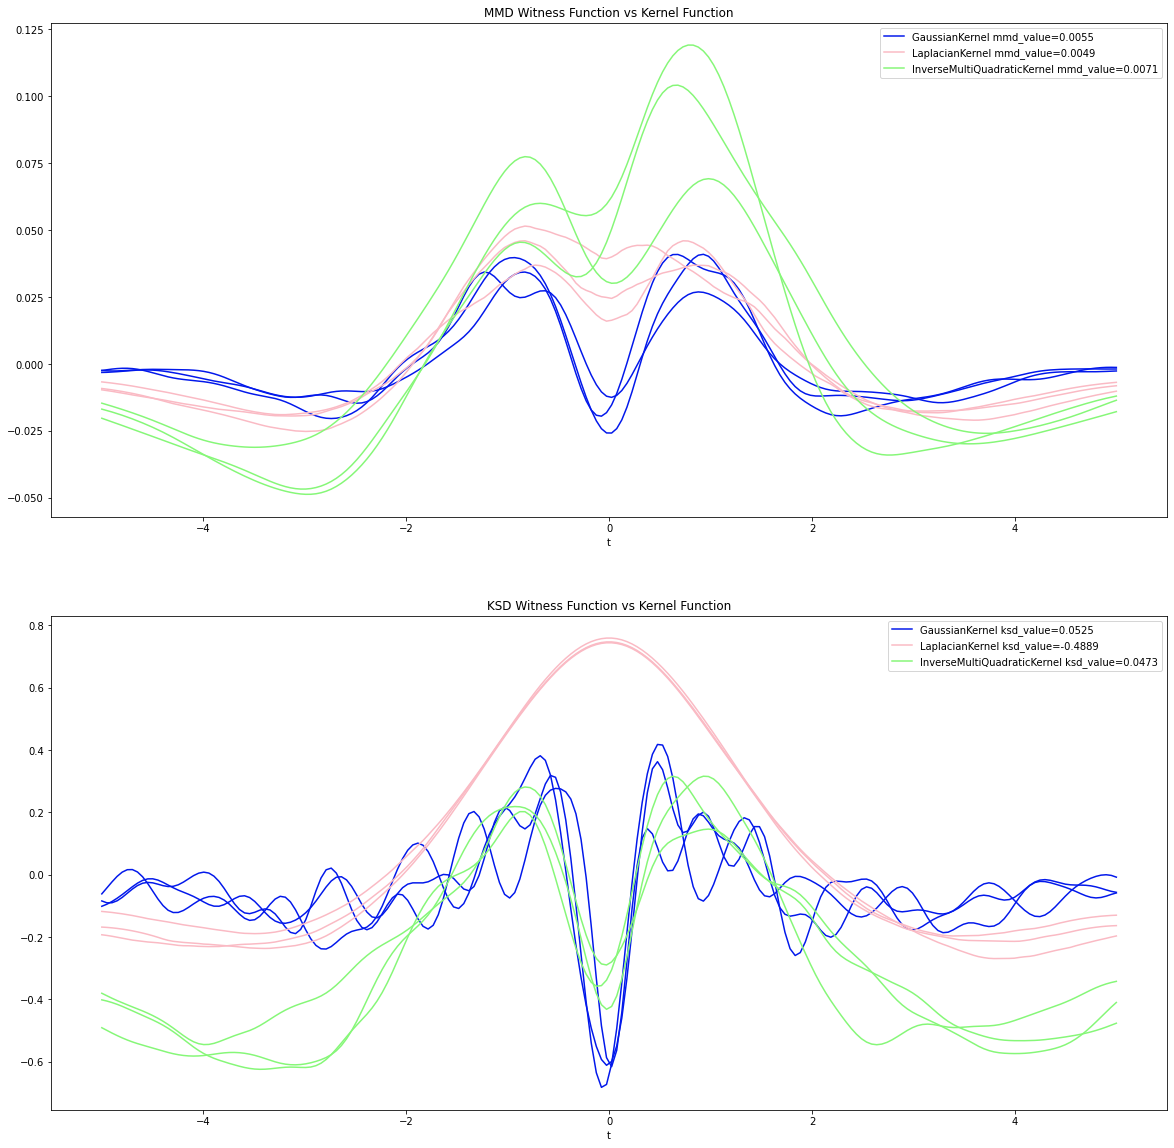

In [5]:
n_trials = 3
sigmas = np.logspace(-3, 3, 5)
fig, ax = plt.subplots(2, 1)
fig.set_figwidth(20)
fig.set_figheight(20)
n_sample = int(2e3)
t = np.linspace(-5, 5, 200).reshape(-1, 1)
p1 = Gaussian(mu=np.zeros((1,)), covariance=np.eye(1))
kernels = [
    GaussianKernel(sigma=10),
    LaplacianKernel(sigma=1),
    InverseMultiQuadraticKernel(c=0.5, beta=-0.5),
]
for i, kernel in enumerate(kernels):
    mmd = MaximumMeanDiscrepancy(kernel=kernel)
    stein_kernel = SteinKernel(
        distribution=p1,
        kernel=kernel,
    )
    ksd = KernelSteinDiscrepancy(stein_kernel=stein_kernel)
    c = np.random.rand(
        3,
    )
    for j in range(n_trials):
        x = p1.sample(n_sample)
        y = np.random.laplace(loc=0.0, scale=1.0, size=n_sample).reshape(-1, 1)
        mmd_witness_values = mmd.witness_function(x, y, t)
        ksd_witness_values = ksd.witness_function(
            x=y,
            t=t,
        )
        if j == 0:
            mmd_value = np.round(float(mmd.compute(x, y)), 4)
            ax[0].plot(
                t,
                mmd_witness_values,
                c=c,
                label=f"{type(kernel).__name__} {mmd_value=}",
            )
            ksd_value = np.round(float(ksd.compute(y)), 4)
            ax[1].plot(
                t,
                ksd_witness_values,
                c=c,
                label=f"{type(kernel).__name__} {ksd_value=}",
            )
        else:
            ax[0].plot(t, mmd_witness_values, c=c)
            ax[1].plot(t, ksd_witness_values, c=c)

ax[0].set_title("MMD Witness Function vs Kernel Function")
ax[0].set_xlabel("t")
ax[0].legend()

ax[1].set_title("KSD Witness Function vs Kernel Function")
ax[1].set_xlabel("t")
ax[1].legend()
plt.show()

## MNIST MMD 

In [6]:
from sklearn.datasets import fetch_openml

We can also plot the witness function between samples of MNIST. This is a bit more tricky because the images have 784 pixels and thus are viewed to be generated from 784 dimensional distributions. This then results in a 784 dimensional witness function. Below we visualise the witness function by tracing the path of this function along a subset of these dimensions.

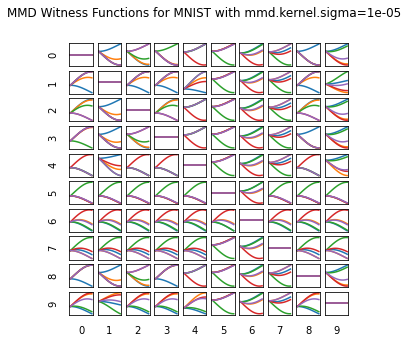

In [7]:
mnist = fetch_openml("mnist_784")
x = np.array(mnist.data)
y = mnist.target
n_t = 50
num_random_pixels = 5

random_pixels = np.argsort(np.std(x, axis=0))[-num_random_pixels:]

t = np.zeros((num_random_pixels, n_t, 784))
for i, random_pixel in enumerate(random_pixels):
    t[i, :, random_pixel] = np.linspace(0, 255, n_t)
mnist_mmd_witness_function_gauss = np.zeros((10, 10, num_random_pixels, n_t))
n_samples = 2
sigma = 1e-5
mmd = MaximumMeanDiscrepancy(kernel=GaussianKernel(sigma))
for i in range(10):
    a = x[y == str(i)][:n_samples]
    for j in range(10):
        if i == j:
            b = x[y == str(j)][n_samples : 2 * n_samples]
        else:
            b = x[y == str(j)][:n_samples]
            for k in range(num_random_pixels):
                mnist_mmd_witness_function_gauss[i, j, k, :] = mmd.witness_function(
                    a, b, t[k, :, :]
                )
fig, axs = plt.subplots(10, 10)
fig.set_figwidth(5)
fig.set_figheight(5)
for i in range(10):
    for j in range(10):
        for k in range(num_random_pixels):
            axs[i][j].plot(mnist_mmd_witness_function_gauss[i, j, k, :])
            axs[i][j].tick_params(
                axis="x",
                which="both",
                bottom=False,
                top=False,
            )
            axs[i][j].tick_params(
                axis="y",
                which="both",
                left=False,
                right=False,
            )
            axs[i][j].xaxis.set_ticklabels([])
            axs[i][j].yaxis.set_ticklabels([])
            axs[i][j].set_xlabel(j)
            if j == 0:
                axs[i][j].set_ylabel(i)
fig.suptitle(f"MMD Witness Functions for MNIST with {mmd.kernel.sigma=}")
plt.show()

We can see that along the diagonal, the witness functions are all flat. This makes sense as the x and y samples are from the same digit. But for all other plots, we can see witness functions for the different pixels.

If we choose a larger sigma and generate the same plots, we can see that the witness function is no longer able to pick up the discrepancies between the digits.

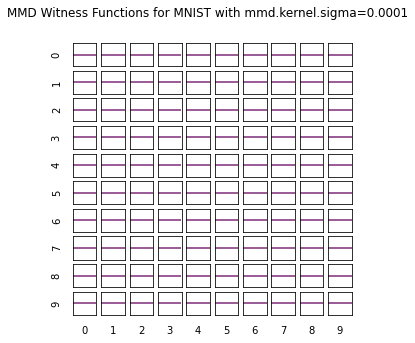

In [8]:
sigma = 1e-4
mmd = MaximumMeanDiscrepancy(kernel=GaussianKernel(sigma))
for i in range(10):
    a = x[y == str(i)][:n_samples]
    for j in range(10):
        if i == j:
            b = x[y == str(j)][n_samples : 2 * n_samples]
        else:
            b = x[y == str(j)][:n_samples]
            for k in range(num_random_pixels):
                mnist_mmd_witness_function_gauss[i, j, k, :] = mmd.witness_function(
                    a, b, t[k, :, :]
                )
fig, axs = plt.subplots(10, 10)
fig.set_figwidth(5)
fig.set_figheight(5)
for i in range(10):
    for j in range(10):
        for k in range(num_random_pixels):
            axs[i][j].plot(mnist_mmd_witness_function_gauss[i, j, k, :])
            axs[i][j].tick_params(
                axis="x",
                which="both",
                bottom=False,
                top=False,
            )
            axs[i][j].tick_params(
                axis="y",
                which="both",
                left=False,
                right=False,
            )
            axs[i][j].xaxis.set_ticklabels([])
            axs[i][j].yaxis.set_ticklabels([])
            axs[i][j].set_xlabel(j)
            if j == 0:
                axs[i][j].set_ylabel(i)
fig.suptitle(f"MMD Witness Functions for MNIST with {mmd.kernel.sigma=}")
plt.show()

All the witness functions are flat lines. This shows the importance of choosing an appropriate kernel function.